In [9]:
# dpg_train.py
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Ornstein-Uhlenbeck 噪声
class OUNoise:
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.3, sigma_min=0.1, decay=0.995):
        self.mu = mu * np.ones(action_dim)
        self.theta = theta
        self.sigma = sigma
        self.sigma_min = sigma_min
        self.decay = decay
        self.state = np.copy(self.mu)

    def reset(self):
        self.state = np.copy(self.mu)

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        self.sigma = max(self.sigma_min, self.sigma * self.decay)
        return self.state

# 演员网络
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action

# 批评家网络
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

# 奖励标准化器
class RewardNormalizer:
    def __init__(self, mean=0, std=1, clip=10):
        self.mean = mean
        self.std = std
        self.clip = clip
        self.mean_var = deque(maxlen=100)
        self.std_var = deque(maxlen=100)

    def update(self, reward):
        self.mean_var.append(reward)
        self.std_var.append(reward ** 2)
        self.mean = np.mean(self.mean_var)
        self.std = np.sqrt(max(np.mean(self.std_var) - self.mean ** 2, 1e-6))

    def normalize(self, reward):
        norm_reward = (reward - self.mean) / (self.std + 1e-6)
        return np.clip(norm_reward, -self.clip, self.clip)

# DPG算法
class DPG:
    def __init__(self, state_dim, action_dim, max_action, device):
        self.device = device
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=5e-5)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-4)

        self.max_action = max_action
        self.memory = deque(maxlen=100000)
        self.batch_size = 256
        self.gamma = 0.99
        self.tau = 0.005
        self.noise = OUNoise(action_dim)
        self.reward_normalizer = RewardNormalizer()

    def store_transition(self, state, action, reward, next_state, done):
        self.reward_normalizer.update(reward)
        norm_reward = self.reward_normalizer.normalize(reward)
        self.memory.append((state, action, norm_reward, next_state, done))

    def sample(self):
        transitions = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor(np.array([t[0] for t in transitions])).to(self.device)
        actions = torch.FloatTensor(np.array([t[1] for t in transitions])).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in transitions]).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array([t[3] for t in transitions])).to(self.device)
        dones = torch.FloatTensor([t[4] for t in transitions]).unsqueeze(1).to(self.device)
        return states, actions, rewards, next_states, dones

    def update(self):
        if len(self.memory) < self.batch_size:
            return 0, 0

        states, actions, rewards, next_states, dones = self.sample()

        # 更新批评家
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q = self.critic_target(next_states, next_actions)
            target_q = rewards + (1 - dones) * self.gamma * target_q

        current_q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()

        # 更新演员
        actor_actions = self.actor(states)
        actor_loss = -self.critic(states, actor_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
        self.actor_optimizer.step()

        # 软更新目标网络
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state).cpu().numpy().flatten()
        action = (action + self.noise.noise()).clip(-self.max_action, self.max_action)
        return action

    def save_model(self, actor_path="actor.pth", critic_path="critic.pth"):
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

def train_dpg():
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    agent = DPG(state_dim, action_dim, max_action, device)
    episodes = 1000
    max_steps = 1000
    train_rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        agent.noise.reset()

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done or truncated)
            actor_loss, critic_loss = agent.update()

            state = next_state
            episode_reward += reward

            if done or truncated:
                break

        train_rewards.append(episode_reward)
        print(f"Episode {episode + 1}, Train Reward: {episode_reward:.2f}, "
              f"Actor Loss: {actor_loss:.4f}, Critic Loss: {critic_loss:.4f}")

    # 保存模型和奖励
    agent.save_model()
    np.save("train_rewards.npy", train_rewards)
    env.close()
    print("Training completed. Models and rewards saved.")

if __name__ == "__main__":
    train_dpg()

Episode 1, Train Reward: -1339.58, Actor Loss: 0.0000, Critic Loss: 0.0000
Episode 2, Train Reward: -1358.28, Actor Loss: 0.0239, Critic Loss: 1.0843
Episode 3, Train Reward: -1388.09, Actor Loss: 0.0447, Critic Loss: 0.6616
Episode 4, Train Reward: -1347.95, Actor Loss: -0.1569, Critic Loss: 0.4168
Episode 5, Train Reward: -1493.61, Actor Loss: -0.2398, Critic Loss: 0.3711
Episode 6, Train Reward: -1597.79, Actor Loss: -0.4185, Critic Loss: 0.2756
Episode 7, Train Reward: -1247.54, Actor Loss: -0.5629, Critic Loss: 0.2871
Episode 8, Train Reward: -1619.22, Actor Loss: -0.1203, Critic Loss: 0.3062
Episode 9, Train Reward: -1637.68, Actor Loss: -0.3829, Critic Loss: 0.2852
Episode 10, Train Reward: -1557.84, Actor Loss: -0.4288, Critic Loss: 0.2613
Episode 11, Train Reward: -1821.30, Actor Loss: -0.7047, Critic Loss: 0.3907
Episode 12, Train Reward: -1619.03, Actor Loss: -0.8079, Critic Loss: 0.7380
Episode 13, Train Reward: -1612.30, Actor Loss: -0.5480, Critic Loss: 0.8701
Episode 14,

/tmp/ipykernel_600290/3507782479.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("actor.pth"))


Episode 1, Eval Reward: -183.99 ± 53.37
Episode 11, Eval Reward: -155.07 ± 102.37
Episode 21, Eval Reward: -211.62 ± 44.78
Episode 31, Eval Reward: -170.32 ± 58.43
Episode 41, Eval Reward: -143.29 ± 89.77
Episode 51, Eval Reward: -206.09 ± 82.20
Episode 61, Eval Reward: -164.89 ± 55.91
Episode 71, Eval Reward: -117.94 ± 3.96
Episode 81, Eval Reward: -49.03 ± 57.93
Episode 91, Eval Reward: -165.09 ± 53.58
Episode 101, Eval Reward: -95.94 ± 89.16
Episode 111, Eval Reward: -118.09 ± 72.69
Episode 121, Eval Reward: -141.60 ± 87.34
Episode 131, Eval Reward: -140.71 ± 42.95
Episode 141, Eval Reward: -164.60 ± 91.02
Episode 151, Eval Reward: -116.64 ± 1.49
Episode 161, Eval Reward: -178.54 ± 73.98
Episode 171, Eval Reward: -119.79 ± 131.84
Episode 181, Eval Reward: -163.14 ± 55.07
Episode 191, Eval Reward: -168.49 ± 57.84
Episode 201, Eval Reward: -119.47 ± 73.65
Episode 211, Eval Reward: -158.17 ± 106.69
Episode 221, Eval Reward: -169.29 ± 97.82
Episode 231, Eval Reward: -143.34 ± 47.98
Epis

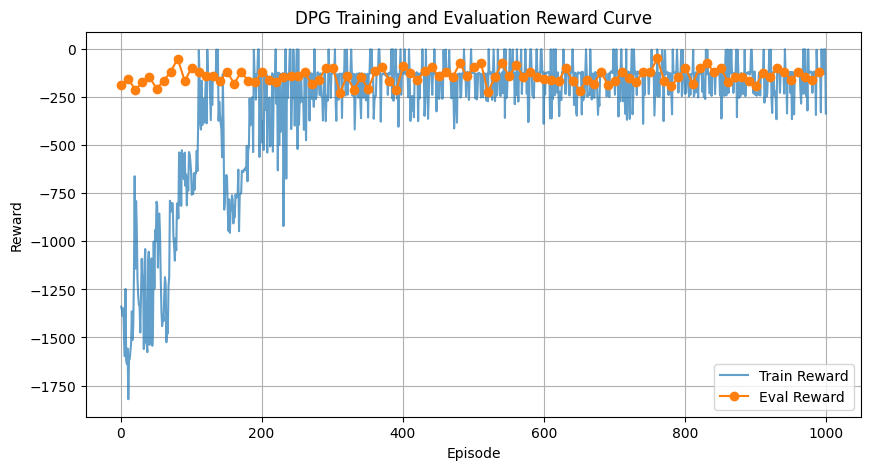

In [11]:
# dpg_evaluate.py
import matplotlib.pyplot as plt

def evaluate_policy(actor, env, device, eval_episodes=5):
    eval_rewards = []
    for _ in range(eval_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = actor(state_tensor).cpu().numpy().flatten()
            state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
        eval_rewards.append(episode_reward)
    return np.mean(eval_rewards), np.std(eval_rewards)

def evaluate_dpg():
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载演员模型
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load("actor.pth"))
    actor.eval()

    # 加载训练奖励
    train_rewards = np.load("train_rewards.npy")
    episodes = len(train_rewards)

    # 评估
    eval_rewards = []
    eval_episodes = []
    eval_interval = 10
    for episode in range(0, episodes, eval_interval):
        mean_reward, std_reward = evaluate_policy(actor, env, device)
        eval_rewards.append(mean_reward)
        eval_episodes.append(episode + 1)
        print(f"Episode {episode + 1}, Eval Reward: {mean_reward:.2f} ± {std_reward:.2f}")

    env.close()

    # 绘制奖励曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, episodes + 1), train_rewards, label="Train Reward", alpha=0.7)
    plt.plot(eval_episodes, eval_rewards, label="Eval Reward", marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DPG Training and Evaluation Reward Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_dpg()

In [13]:
# dpg_test.py
def test_dpg():
    env = gym.make("Pendulum-v1", render_mode="human")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载演员模型
    actor = Actor(state_dim, action_dim, max_action).to(device)
    actor.load_state_dict(torch.load("actor.pth"))
    actor.eval()

    # 运行测试回合
    print("Running test episodes with rendering...")
    for i in range(5):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        while not (done or truncated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = actor(state_tensor).cpu().numpy().flatten()
            state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            env.render()
        print(f"Test Episode {i + 1}, Reward: {episode_reward:.2f}")
    env.close()

test_dpg()

/tmp/ipykernel_600290/1792456822.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load("actor.pth"))


Running test episodes with rendering...
Test Episode 1, Reward: -124.49
Test Episode 2, Reward: -226.43
Test Episode 3, Reward: -218.87
Test Episode 4, Reward: -119.20
Test Episode 5, Reward: -116.52
